# Installing necessary dependencies

In [1]:
# %pip install -Uq 'unstructured[pdf]' pillow lxml
# %pip install -Uq chromadb tiktoken redis
# %pip install -Uq langchain langchain-community langchain-anthropic langchain-groq langchain-ollama
# %pip install -U langchain-chroma
# %pip install -Uq python-dotenv

# Redis config

Prepare redis for chunk caching

In [2]:
from redis import Redis

redis = Redis(decode_responses=True)

try:
    redis.ping()
    print("Redis is ready")
except Exception as e:
    print("Redis is not ready", e)
    raise e

Redis is ready


# Data extraction

Extract the element of the PDF. Could be: Text, Images, Tables, etc.

In [3]:
from unstructured.partition.pdf import partition_pdf

OUTPUT_PATH = './pdf/'
FILENAME = 'Photography-101-Pocket-Guide.pdf'
FILEPATH = OUTPUT_PATH + FILENAME
KEY = FILENAME.split('.')[0]

def extract_images_from_chunk(chunks):
    images = []
    for chunk in chunks:
        elements = chunk.metadata.orig_elements
        for el in elements:
            if 'Image' in str(type(el)):
                images.append(el.metadata.image_base64)
    return images

if not redis.keys(f'{FILENAME.split(".")[0]}:*'):
    print('[INFO] Partitioning PDF and storing in Redis')
    chunks = partition_pdf(
        filename=FILEPATH,
        extract_image_block_types=['Image'],
        extract_image_block_to_payload=True, # if True, will extract base64
        chunking_strategy='by_title', # 'by_title' or 'basic'
        max_characters=10000,
        combine_text_under_n_chars=2000,
        new_after_n_chars=6000
    )

    print(f'[INFO] Total data chunk: {len(chunks)}')

    texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]
    images = extract_images_from_chunk(texts)
    texts = [chunk.text for chunk in texts]

    for i, text in enumerate(texts):
        key = KEY + f':text_{i}'
        text_byte = text.encode('utf-8')
        redis.set(key, text_byte)

    for i, image in enumerate(images):
        key = KEY + f':image_{i}'
        image_byte = image.encode('utf-8')
        redis.set(key, image_byte)

    
    chunks = {'text': texts, 'image': images}
    print('[INFO] Chunks stored in Redis')
else:
    print('[INFO] Fetching data from Redis')
    chunks = {'text': [], 'image': []}
    for key in redis.keys(f'{KEY}:*'):
        if 'text_' in key:
            chunks['text'] += [redis.get(key)]
        elif 'image_' in key:
            chunks['image'] += [redis.get(key)]

[INFO] Fetching data from Redis


Display the image example

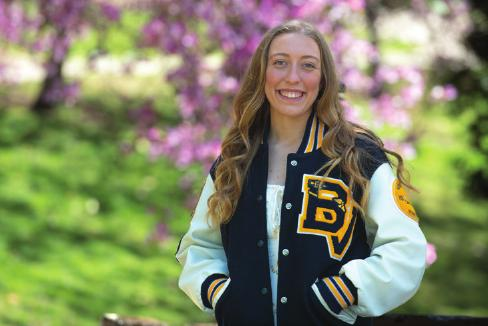

In [4]:
import base64
from IPython.display import display, Image

def display_base64(base64_code):
    image_data = base64.b64decode(base64_code)
    display(Image(image_data))

display_base64(chunks['image'][0])

In [5]:
chunks['text']

['the shot.\n\nEXPOSURE BRACKETING/HDR PHOTOGRAPHY\n\nBracketing is a technique where you take a series of images with a set exposure difference (such as one or two stops) between each photo. This allows you to capture all the avail- able photographic data in a scene—including details in both highlights and shadows—and then combine them (sometimes\n\n25\n\nin the camera, but mostly in software such as Adobe Lightroom) to create a high-dynamic range (HDR) image.\n\nBusine\n\nUSING THE HISTOGRAM\n\nA histogram is a graphical representation showing the distri- bution of tones in your image. The left side of the histogram represents the shadows and dark areas, while the right side represents the highlights and bright areas. Any data that is pure black (on the left of the graph) or pure white (on the right of the graph) is usually unwanted. You can use the histogram as a guide to help you gauge your exposure.\n\nSome photographers also use the histogram when shooting to employ a technique c

In [6]:
print(f'Total text chunk: {len(chunks["text"])}')
print(f'Total image chunk: {len(chunks["image"])}')

Total text chunk: 15
Total image chunk: 41


# Summarize the data

In [7]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

RAW_PROMPT_TEXT = """Summarize the following text in a concise, relevant manner. 
Do not provide any introduction, explanation, disclaimers, or personal remarks. 
Only present the summarized content. 
Use the text below as your source material, and respond with the condensed version of that text alone, without additional context or commentary.

Text chunk: 
{element}
"""

PROMPT_TEXT = ChatPromptTemplate.from_template(RAW_PROMPT_TEXT)

# text summary chain
text_summarizer = ChatGroq(model="llama-3.1-8b-instant", temperature=0.5, api_key=os.getenv('GROQ_API_KEY'))
summarize_chain = PROMPT_TEXT | text_summarizer | StrOutputParser()

### Text summary

In [8]:
text_summarize = summarize_chain.batch(chunks['text'], {'max_concurrency': 3})

In [9]:
print(f'Total text summary: {len(text_summarize)}')
text_summarize

Total text summary: 15


['Exposure Bracketing/HDR Photography: \nTake a series of images with a set exposure difference to capture details in highlights and shadows, then combine them to create a high-dynamic range image.\n\nUsing the Histogram: \n- A histogram shows the distribution of tones in an image.\n- It helps gauge exposure and can be used for "expose to the right" technique to create a robust RAW file and achieve the widest dynamic range.\n\nComposition: \n- The rule of thirds involves placing subjects where lines intersect on a grid.\n- For landscape photography, place the horizon line at the top or bottom third of the frame.\n- For portrait photography, align eyes with the top third of the frame.',
 '05 ADVANCED SHOOTING TECHNIQUES \n- AUTO ISO: 24 \n- BACK BUTTON FOCUS: 24 \n- FOCUS AND COMPOSITION: 25 \n- EXPOSURE BRACKETING/HDR PHOTOGRAPHY: 25 \n- USING THE HISTOGRAM: 26\n\n06 COMPOSITION TIPS \n- RULE OF THIRDS: 27 \n- FILL THE FRAME: 28 \n- NEGATIVE SPACE: 29 \n- LEADING LINES: 30 \n- PATTERNS

### Image summary

In [10]:
from langchain_anthropic import ChatAnthropic

RAW_PROMPT_IMAGE = """Describe the image in detail. For context, the image is part of a photography book explaining the concept of photography
"""

MESSAGES = [
    (
        'user',
        [
            {'type': 'text', 'text': RAW_PROMPT_IMAGE},
            {
                'type': 'image_url',
                'image_url': {'url': 'data:image/jpeg;base64,{image}'}
            }
        ]
    )
]

PROMPT_IMAGE = ChatPromptTemplate.from_messages(MESSAGES)
image_summarizer = ChatAnthropic(model='claude-3-5-sonnet-20241022', api_key=os.getenv('ANTHROPIC_API_KEY'))
describe_chain = PROMPT_IMAGE | image_summarizer | StrOutputParser()

In [11]:
import time

batch_size = 5
image_summarize = []

for i in range(0, len(chunks['image']), batch_size):
    batch = chunks['image'][i:i + batch_size]
    image_summarize += describe_chain.batch(batch)
    time.sleep(60)

In [12]:
print(f'Total image summary: {len(image_summarize)}')
image_summarize

Total image summary: 41


['This image demonstrates excellent portrait photography technique, particularly in terms of composition and background selection. The subject is wearing a varsity letterman jacket in black and white with a "B" logo, positioned against a beautiful spring backdrop of purple blossoms and green foliage. The shallow depth of field creates a pleasing bokeh effect, where the flowers and leaves are softly blurred while keeping the subject in sharp focus.\n\nThe lighting is natural and well-balanced, likely taken during the "golden hour" or in slightly overcast conditions that provide soft, flattering illumination. The purple flowers create a complementary color contrast with the black and white of the letterman jacket, while the green foliage adds depth to the background.\n\nThe composition follows the rule of thirds, with the subject positioned slightly off-center, creating a more dynamic and engaging image. The photo also demonstrates good use of negative space, allowing the background elem

# Initialize vector store

In [13]:
from langchain_chroma import Chroma
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

vectorstore = Chroma(collection_name=KEY, embedding_function=OllamaEmbeddings(model='nomic-embed-text'), persist_directory='./chromadb')

# storage layer for parent documents
docstore = InMemoryStore()
id_key = 'doc_id'

# retriever layer
retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=docstore, id_key=id_key)

Upsert summaries to the vector database and link to original data

In [14]:
from uuid import uuid4
from langchain_core.documents import Document

# upsert text
doc_ids = [str(uuid4()) for _ in chunks['text']]
summary_texts = [
    Document(
        page_content=summary,
        metadata={id_key: doc_ids[i]}
    ) for i, summary in enumerate(text_summarize)
]

retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, chunks['text'])))

# upser image summary
img_ids = [str(uuid4()) for _ in chunks['image']]
summary_images = [
    Document(
        page_content=summary,
        metadata={id_key: img_ids[i]}
    ) for i, summary in enumerate(image_summarize)
]

retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(img_ids, chunks['image'])))

### Testing

In [15]:
retriever.invoke('what is the basic for photography?')

['03 SETTING UP\n\nEXPOSURE/SHOOTING MODES The exposure/shooting mode that you choose tells the camera how to help you create the exposure. There are four main exposure/shooting modes to choose from:\n\nProgram Auto: The camera determines the exposure by setting the shutter speed and the aperture. The photographer has little control over exposure.\n\nAperture Priority: This is the most popular shooting mode, and the most commonly used for most situations. The pho- tographer sets the aperture, and the camera sets the shutter speed. Best when you want to control the depth of field to either have the subject pop off a blurred background (example: using f/2.8 for a shallow depth of field) or when you need to make sure that all the elements in the image are in focus (example: using f/22 for a deep depth of field).\n\nShutter Speed Priority: The photographer sets the shutter speed, and the camera picks the aperture. This is best used when you want to make sure that you are controlling how mo

# RAG Pipeline

In [18]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic

def parse_docs(docs):
    """Split the documents into text and images"""
    b64, text = [], []
    for doc in docs:
        try:     
            base64.b64decode(doc)
            b64.append(doc)
        except:
            text.append(doc)
    return {'texts': text, 'images': b64}

def build_prompt(kwargs):
    docs_by_type = kwargs['context']
    user_question = kwargs['question']

    context_text = ""
    if len(docs_by_type['texts']) > 0:
        for text in docs_by_type['texts']:
            context_text += text

    # construct prompt with context (including image)
    PROMPT_TEMPLATE = f"""
    Answer the question based only on the following context, which can include text and the image below.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{
        'type': 'text',
        'text': PROMPT_TEMPLATE
    }]

    if len(docs_by_type['images']) > 0:
        for image in docs_by_type['images']:
            prompt_content.append({
                'type': 'image_url',
                'image_url': {'url': f'data:image/jpeg;base64,{image}'}
            })

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content)
        ]
    )

chain = (
    {
        'context': retriever | RunnableLambda(parse_docs),
        'question': RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatAnthropic(model='claude-3-5-sonnet-20241022', api_key=os.getenv('ANTHROPIC_API_KEY'))
    | StrOutputParser()
)

chain_with_sources = {
    'context': retriever | RunnableLambda(parse_docs),
    'question': RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatAnthropic(model='claude-3-5-sonnet-20241022', api_key=os.getenv('ANTHROPIC_API_KEY'))
        | StrOutputParser()
    )
)

In [20]:
response = chain.invoke(
    'what is the basic for photography?'
)

response

'Based on the provided context, the fundamental basics of photography involve understanding several key elements:\n\n1. Exposure/Shooting Modes:\n- Program Auto: Camera controls both shutter speed and aperture\n- Aperture Priority: Photographer controls aperture, camera sets shutter speed\n- Shutter Speed Priority: Photographer controls shutter speed, camera sets aperture\n- Manual: Photographer controls both shutter speed and aperture\n\n2. Metering Modes, which determine how the camera measures light:\n- Evaluative/Matrix: Measures the whole scene\n- Spot: Measures a small area of the scene\n- Center-Weighted: Prioritizes the central part of the scene\n\nThe image appears to be a table of contents or guide for Photography 101, which covers these basics plus additional topics like:\n- Exposure basics\n- Camera settings\n- Lens information\n- Composition tips\n- Shooting scenarios\n- File formats\n- White balance\n- Focus modes\n\nThese elements form the foundation for understanding ho

In [21]:
response_with_sources = chain_with_sources.invoke(
    'what is the basic for photography?'
)

response_with_sources

{'context': {'texts': ['03 SETTING UP\n\nEXPOSURE/SHOOTING MODES The exposure/shooting mode that you choose tells the camera how to help you create the exposure. There are four main exposure/shooting modes to choose from:\n\nProgram Auto: The camera determines the exposure by setting the shutter speed and the aperture. The photographer has little control over exposure.\n\nAperture Priority: This is the most popular shooting mode, and the most commonly used for most situations. The pho- tographer sets the aperture, and the camera sets the shutter speed. Best when you want to control the depth of field to either have the subject pop off a blurred background (example: using f/2.8 for a shallow depth of field) or when you need to make sure that all the elements in the image are in focus (example: using f/22 for a deep depth of field).\n\nShutter Speed Priority: The photographer sets the shutter speed, and the camera picks the aperture. This is best used when you want to make sure that you 